In [1]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [2]:
import pathlib
import numpy as np

import matplotlib.pyplot as plt

import torch
from torch import nn

import datasets
from transformers import AutoTokenizer

In [3]:
def backward_hook(module, gin, gout):

  # print(f"{len(gin)=}, {len(gout)=}")
  # print(*[f"{i=}, {g.shape=}, min:{(n:=g.norm()).min().item()}, max:{n.max().item()}" for i, g in enumerate(gin)], sep='\n')
  # print(*[f"{i=}, {g.shape=}, min:{(n:=g.norm()).min().item()}, max:{n.max().item()}" for i, g in enumerate(gout)], sep='\n')
  gins.append(gin)
  gouts.append(gout)
  # print(f'{len(gins)=}, {len(gouts)=}')

In [4]:
subpath = '20240425.23:36:53-batch_size_512' # rotator_lima4_noClocks, mse+multiplet, dim128, hdim32, head32, dep3
subpath = '20240429.22:56:02-batch_size_512' # rotator_lima4_hippo, mse+multiplet, dim128, hdim32, head32, dep3
subpath = '20240502.01:12:29-batch_size_512' # rotator_lima4_noClocks, true mse+multiplet, dim128, hdim32, head32, dep3
subpath = '20240502.19:17:09-batch_size_512' # rotator_lima4_noClocks, cos_dist+multiplet, dim128, hdim32, head32, dep3
subpath = '20240502.21:10:49-batch_size_64' # rotator_lima4_noClocks, msmarco, mse+multiplet, dim128, hdim32, head32, dep3
subpath = '20240502.23:36:34-batch_size_512' # noTime, cos_dist+multiplet
subpath = '20240521.13:49:45'

batch_num = 60000
folder_path = pathlib.Path('data/limanet/')

model = torch.load(folder_path/subpath/f'batch_{batch_num}-model.pt', map_location='cpu')
# model = torch.load(folder_path/subpath/f'last_batch-model.pt', map_location='cpu')

model = model.model

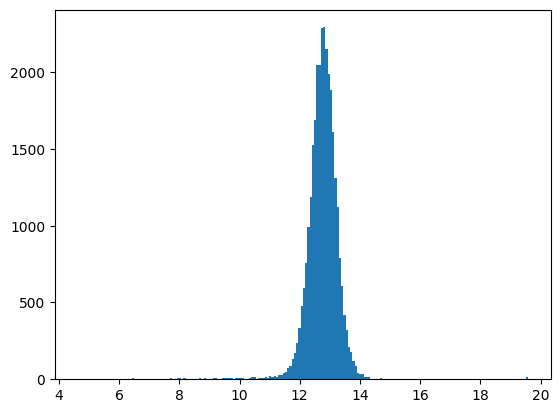

In [5]:
reals = model.predictor.embedding_real.weight
imags = model.predictor.embedding_imag.weight
norms = torch.concat([reals, imags], dim=1).norm(dim=1).detach().cpu().numpy()
fig = plt.figure()
_ = plt.hist(norms, bins=200)

fig.savefig(f'image/param_dist-batch_{batch_num}.png')
# fig.savefig('image/overtrain_param_dist.png')

In [6]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [7]:
argmin, argmax = norms.argmin(), norms.argmax()
print(tokenizer.decode([argmin, argmax]))
print(norms[argmin], norms[argmax])

house -
4.6134887 19.594364


In [8]:
index = norms.argsort()
tokenizer.convert_ids_to_tokens(index[-1:-6:-1])

['-', "'", 'my', 'the', '.']

'##morphism exploration'

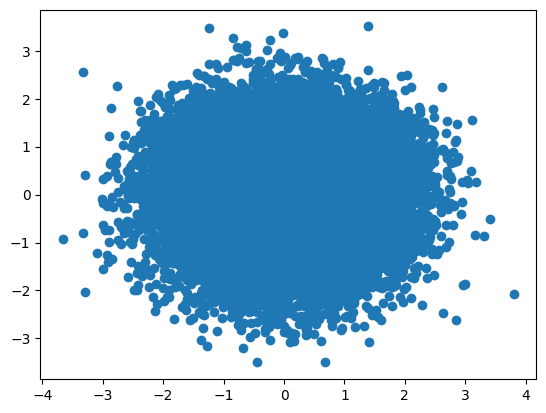

In [9]:
from sklearn.decomposition import PCA

emb = model.all_word_embeddings()
emb = torch.concat([emb.real, emb.imag], dim=-1).detach().numpy()
proj = PCA().fit_transform(emb)
plt.scatter(*proj.T[:2])

tokenizer.decode(proj.T[:2].argmax(axis=1))

In [10]:
dataset = datasets.load_dataset("bookcorpus", cache_dir='~/data1-0756727/cache/huggingface')
dataset['train'][:3]

{'text': ['usually , he would be tearing around the living room , playing with his toys .',
  'but just one look at a minion sent him practically catatonic .',
  "that had been megan 's plan when she got him dressed earlier ."]}

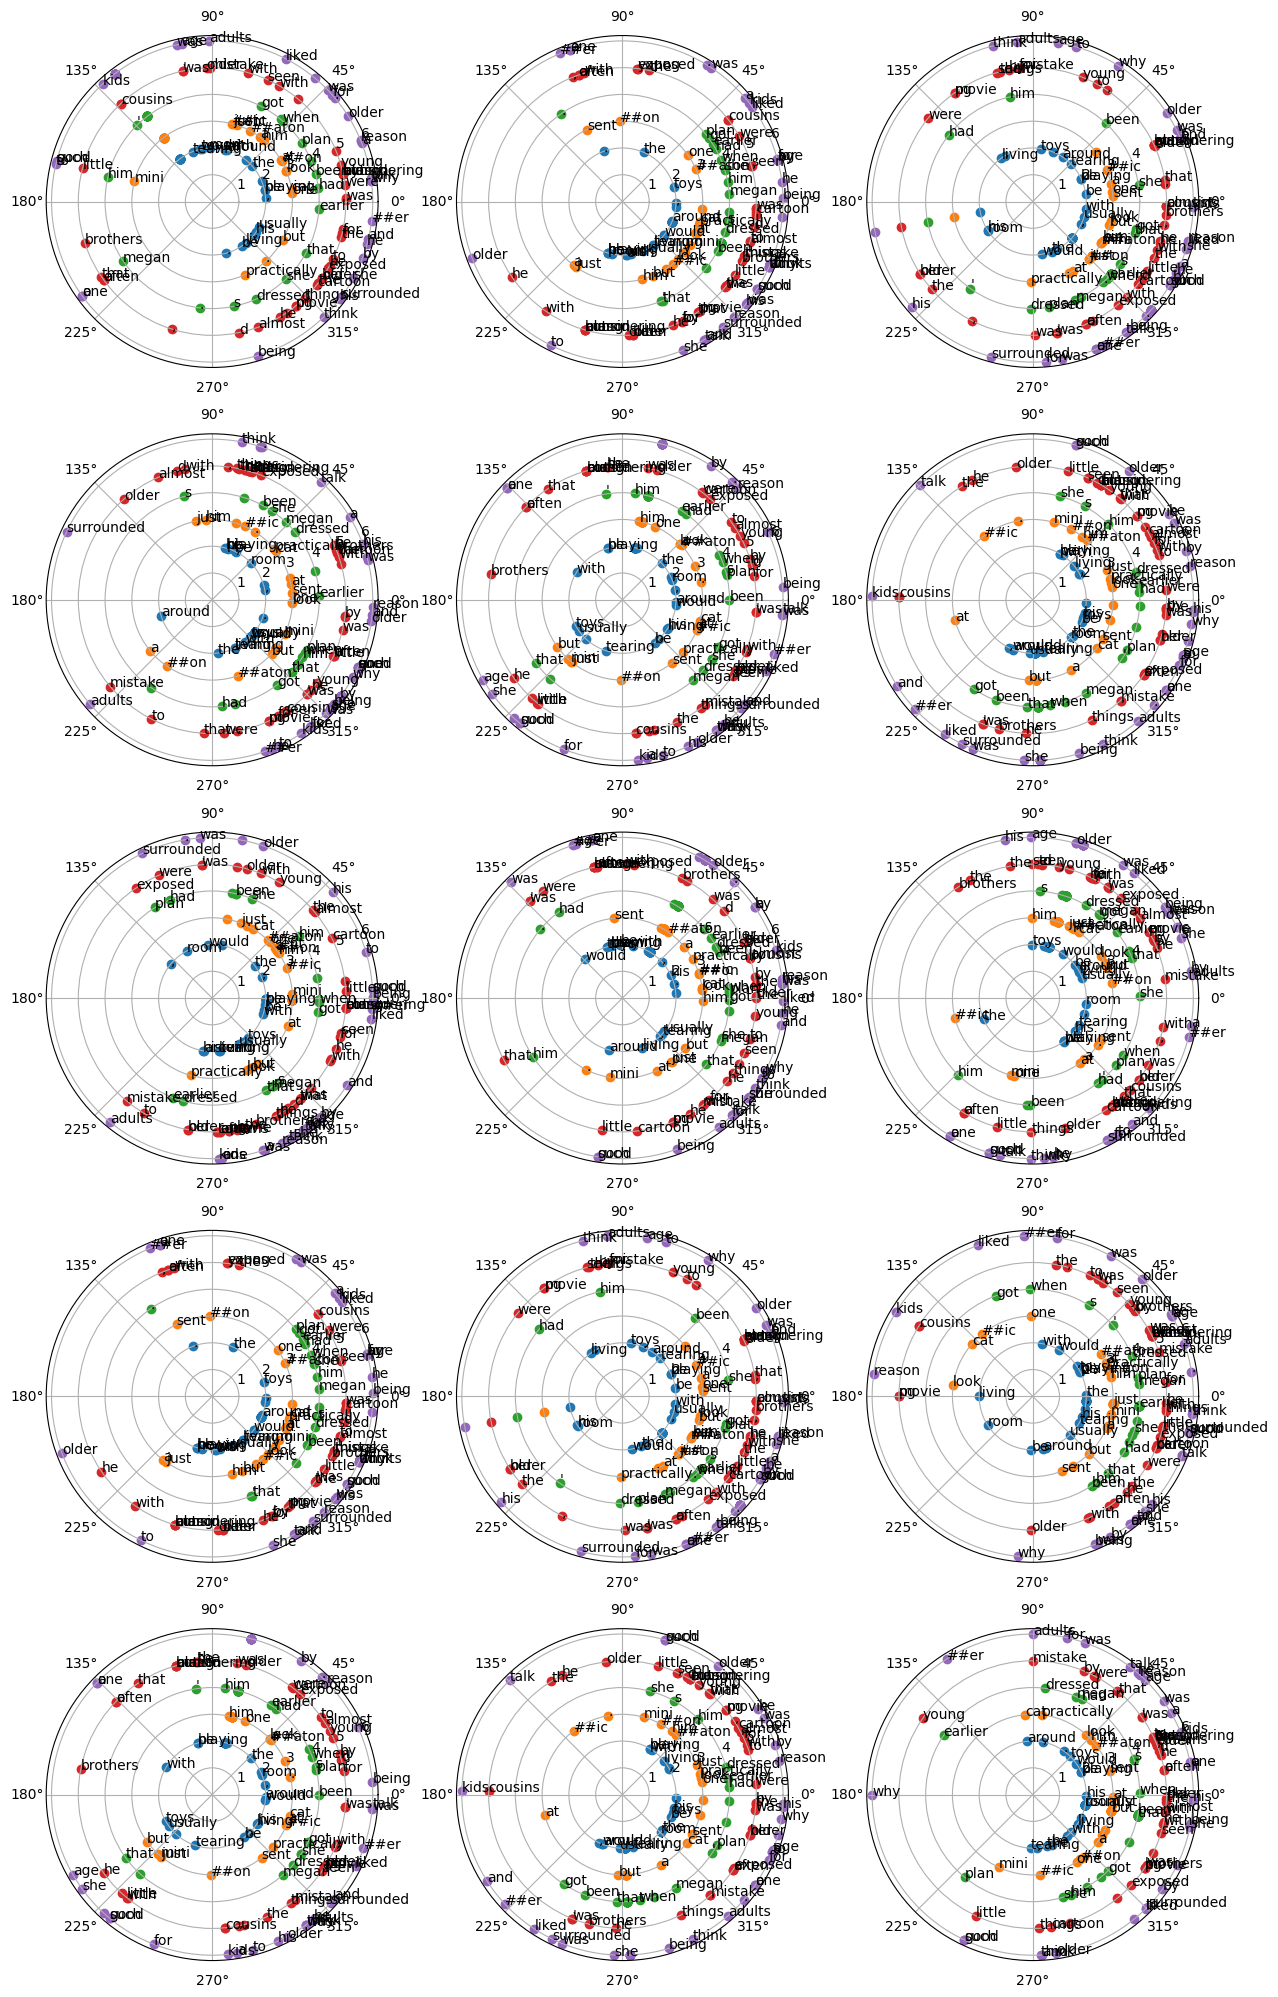

In [11]:
# word angles

samples = dataset['train'][:5]['text']

tokenized = tokenizer(samples, padding=True, return_tensors='pt')
# print(tokenized)

input_ids = tokenized['input_ids'].numpy()
angles = model.angle_embedding(tokenized['input_ids']).detach().numpy()
angles.shape

rows = 3
columns = 5

fig, axes = plt.subplots(columns, rows, figsize=[rows*5,columns*5], subplot_kw=dict(projection='polar'))

for k, (input_id, angle) in enumerate(zip(input_ids, angles)):
    sequence = tokenizer.convert_ids_to_tokens(input_id, skip_special_tokens=True)
    
    for i in range(columns):
        for j in range(rows):
            a = angle[:, j*rows+i]
            r = np.full_like(a, k+2)
            axes[i,j].scatter(a, r)

            for t, x, y in zip(sequence, a,r):
                axes[i,j].annotate(t, (x,y))

fig.savefig('image/word_angle.png')

In [12]:
# fig.savefig('fig.png')

/home/adam/miniconda3/envs/lima/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/adam/miniconda3/envs/lima/lib/python3.12/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/home/adam/miniconda3/envs/lima/lib/python3.12/site-packages/matplotlib/text.py:1461: ComplexWarning: Casting complex values to real discards the imaginary part
  x = float(self.convert_xunits(x))
/home/adam/miniconda3/envs/lima/lib/python3.12/site-packages/matplotlib/text.py:1463: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(y))
/home/adam/miniconda3/envs/lima/lib/python3.12/site-packages/matplotlib/text.py:753: ComplexWarning: Casting complex values to real discards the imaginary part
  posx = float(self.convert_xunits(self._x))
/h

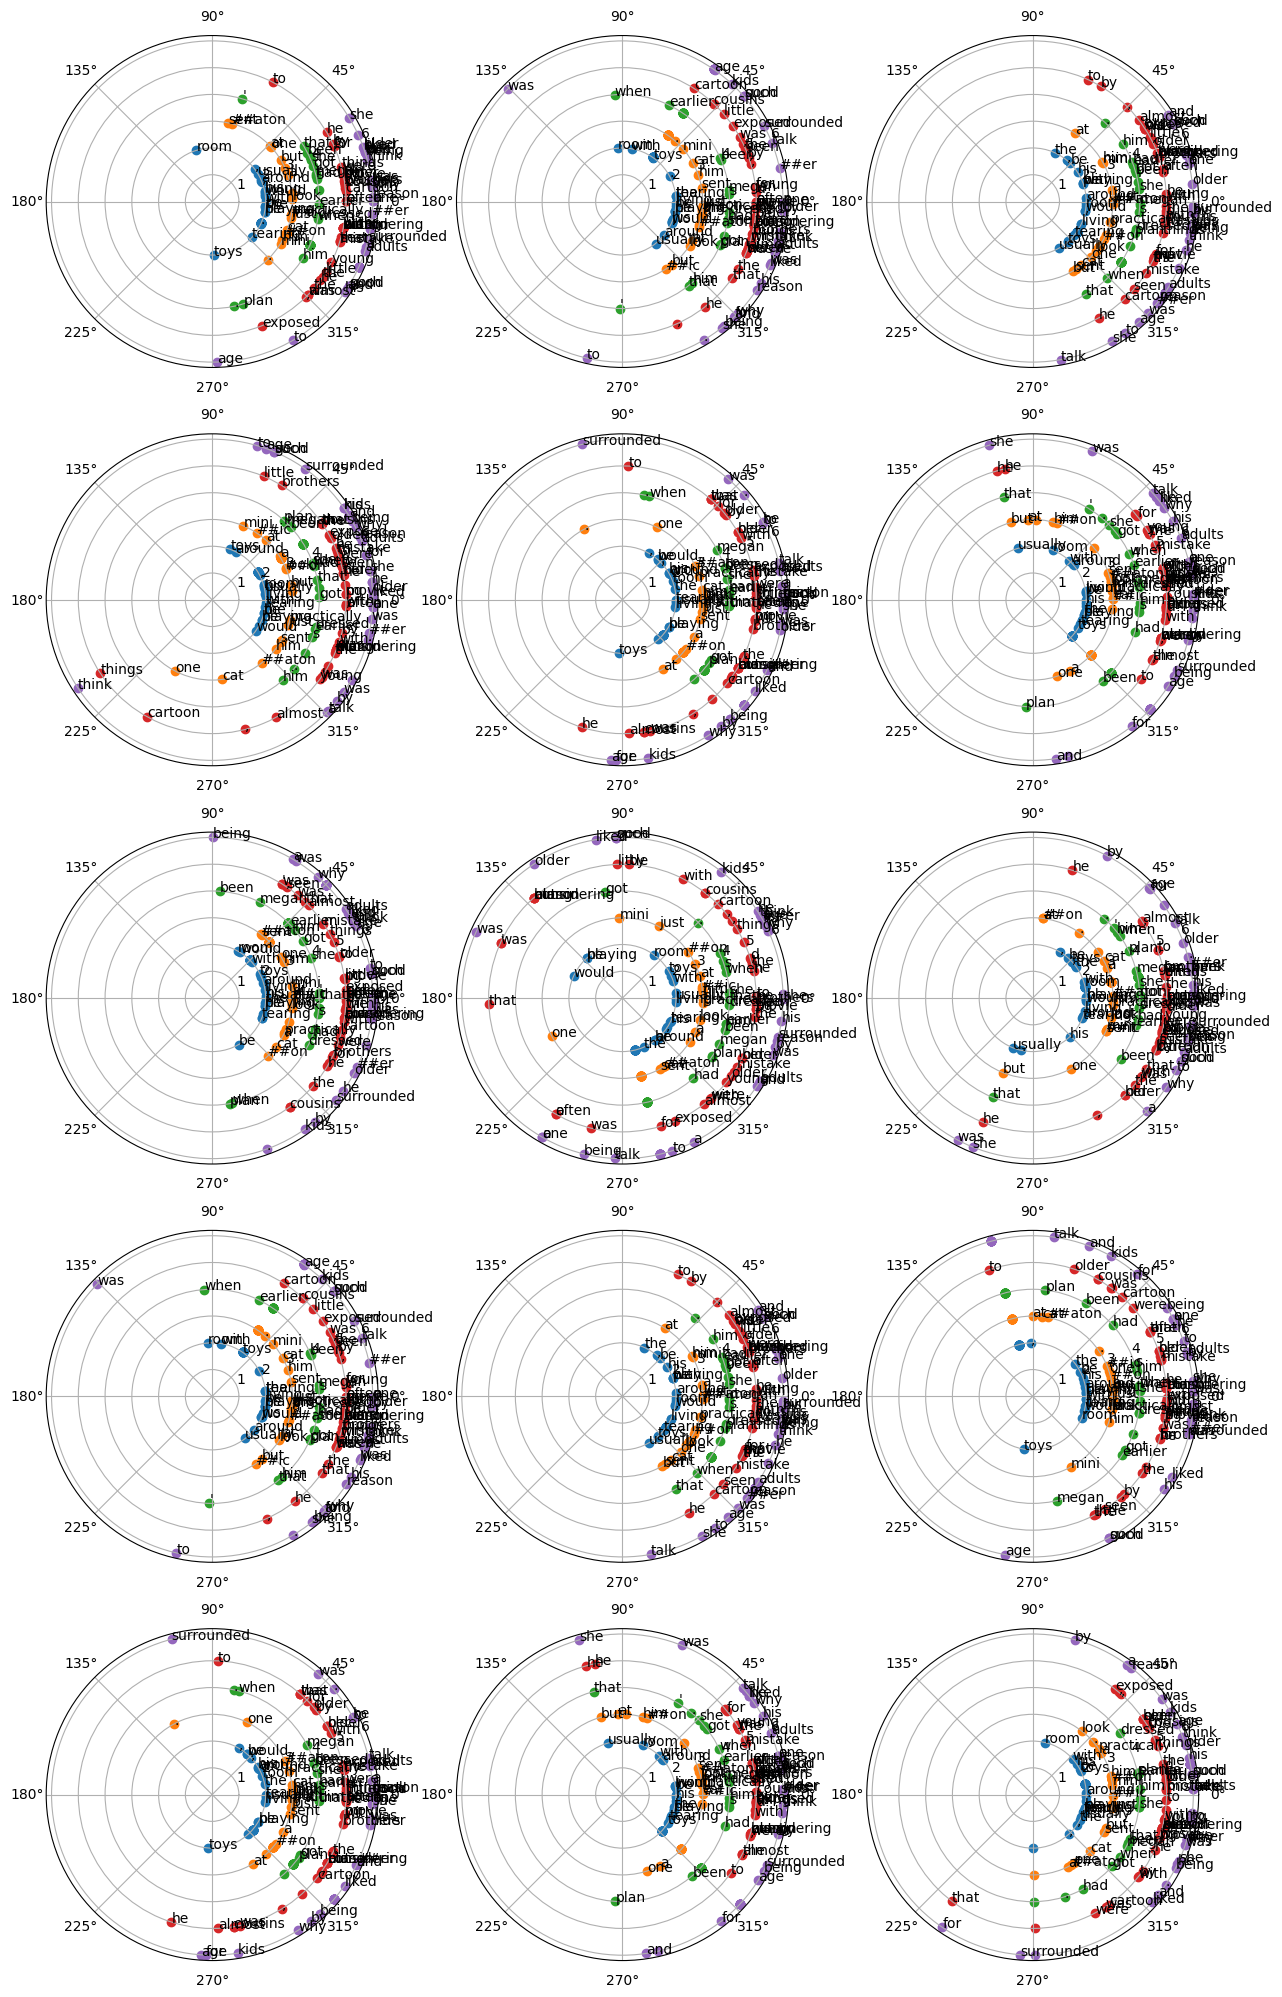

In [13]:
# word vectors

samples = dataset['train'][:5]['text']

tokenized = tokenizer(samples, padding=True, return_tensors='pt')
# print(tokenized)

input_ids = tokenized['input_ids'].numpy()
angles = model.predictor.all_word_embeddings()[tokenized['input_ids']].detach().numpy()
angles.shape

rows = 3
columns = 5

fig, axes = plt.subplots(columns, rows, figsize=[rows*5,columns*5], subplot_kw=dict(projection='polar'))

for k, (input_id, angle) in enumerate(zip(input_ids, angles)):
    sequence = tokenizer.convert_ids_to_tokens(input_id, skip_special_tokens=True)
    
    for i in range(columns):
        for j in range(rows):
            a = angle[:, j*rows+i]
            r = np.full_like(a, k+2)
            axes[i,j].scatter(a, r)

            for t, x, y in zip(sequence, a,r):
                axes[i,j].annotate(t, (x,y))

In [14]:
import sklearn.metrics.pairwise as pairwise

In [15]:
# nearest words, word vectors
target_word = 'she'
num_printing = 30

metric = 'euclidean'
metric = 'cosine'


emb = model.predictor.all_word_embeddings()
emb = torch.concat([emb.real, emb.imag], dim=1).detach().numpy()
target_word_id = tokenizer.encode(target_word, add_special_tokens=False)
dist = pairwise.pairwise_distances(emb[target_word_id], emb, metric=metric)

print('word vectors:\n')
print(tokenizer.convert_ids_to_tokens(dist.argsort()[0, :num_printing]))


emb = model.angle_embedding.weight.detach().numpy()
target_word_id = tokenizer.encode(target_word, add_special_tokens=False)
dist = pairwise.pairwise_distances(emb[target_word_id], emb, metric=metric)

print('\nword angles:\n')
print(tokenizer.convert_ids_to_tokens(dist.argsort()[0, :num_printing]))

word vectors:

['she', 'but', '[unused418]', 'determined', 'rumble', 'highlanders', 'jeans', 'daughter', '##₄', '÷', 'さ', '##code', '##ardo', 'mother', 'caused', '##ister', 'version', 'eduardo', 'headquarters', 'clear', 'regions', 'fielded', 'if', 'granville', 'cheerfully', '##dle', 'then', 'flame', 'concerned', 'reelected']

word angles:

['she', 'devi', 'exciting', '?', 'her', 'noble', 'night', 'spirit', '##fied', 'as', 'openly', '##iously', 'scrape', 'fame', 'ground', 'warfare', 'exhibiting', '##under', 'small', 'never', 'sauce', 'marching', 'ticket', 'ann', 'testosterone', 'flash', 'sweatshirt', 'venom', 'uncertain', 'brighter']


In [16]:
# dist = pairwise.pairwise_distances(emb, emb).detach()
# np.fill_diagonal(dist, np.nan)
# np.nanmin(dist), np.nanmax(dist)